In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [36]:
data = pd.read_csv("../data/train.csv")

In [4]:
def define_shape(df: pd.DataFrame) -> tuple:
    """
    Returns dimensions of pandas dataframe.
    Input:
    df (pd.DataFrame): pandas dataframe
    Output:
    Returns tuple with number of rows and columns of dataframe.
    """
    return df.shape


def distinguish_data_types(df: pd.DataFrame) -> list:
    """
    Categorizes columns of dataframe on numeric, categorial or object-like type, according to datatype and number of unique objects in it.
    If number of unique objects less than 5 it consider as categorial data type, rather than numeric or object-like.
    Input:
    df (pd.DataFrame): pandas dataframe
    Output:
    numeric_column_names, categorial_column_names, object_column_names (lists): contain names of columns of each type.
    """
    categ_values = df.select_dtypes(include=['object'])
    numeric_values = df.select_dtypes(exclude=['object'])
    categorial_column_names = [] 
    object_column_names = []   
    numeric_column_names = []   
    for column in categ_values:
        category = categ_values[column].unique()
        if len(category) < 5:
            categorial_column_names.append(column)
        else:
            object_column_names.append(column)
    for column in numeric_values:
        numeric = numeric_values[column].unique()
        if len(numeric) < 15:
            categorial_column_names.append(column)
        else:
            numeric_column_names.append(column)   
    return numeric_column_names, categorial_column_names, object_column_names


def count_outliers(df: pd.DataFrame, name: str) -> int:
    """
    Counts number of outliers for numerical data.
    Input:
    df (pd.DataFrame): pandas dataframe
    name (str): name of column with numeric data
    Output:
    outliers_count (int): number of outliers.
    """
    q1 = df[name].quantile(0.25) 
    q3 = df[name].quantile(0.75) 
    IQR = q3 - q1
    lower_border = q1 - 1.5 * IQR
    upper_border = q3 + 1.5 * IQR
    outliers_count = ((df[name] < (q1 - 1.5 * IQR)) | (df[name] > (q3 + 1.5 * IQR))).sum()
    return outliers_count


def count_missing_values(df: pd.DataFrame) -> int:
    """
    Counts number of missing values in entire dataframe, rows and columns with missing values.
    Input:
    df (pd.DataFrame): pandas dataframe
    Output:
    nan_count, count_rows_missing_values, count_columns_missing_values (int): number of missing values for entire dataframe, rows and columns with missing values accordingly.
    """
    nan_count = df.isna().sum().sum()
    rows_missing_values = df.dropna(axis=0).shape
    columns_missing_values = df.dropna(axis=1).shape
    count_rows_missing_values = df.shape[0] - rows_missing_values[0]
    count_columns_missing_values = df.shape[1] - columns_missing_values[1]
    return nan_count, count_rows_missing_values, count_columns_missing_values


def count_duplicates(df: pd.DataFrame) -> int:
    """
    Counts number of duplicated rows.
    Input:
    df (pd.DataFrame): pandas dataframe
    Output:
    count_duplicates (int): number of duplicated rows in dataframe.
    """
    duplicates = df.drop_duplicates().shape 
    count_duplicates = df.shape[0] - duplicates[0]
    return count_duplicates


def run_eda(df: pd.DataFrame):
    """
    Function returns to standard output result of Exploratory Data Analysis (EDA).
    Analysis includes:
    - Number of observations (rows) and parameters (columns);
    - Sorting data into numeric, categorical and object-like data and the number of data of each type;
    - Frequecny of each value and total number of observations for categorial data;
    - Max and min values, median, mean and quantilies for numeric data as well as number of outliers;
    - Number of missing values in entire dataframe, rows and columns with missing values;
    - Number of duplicated rows in dataframe.

    Input:
    df (pd.DataFrame): pandas dataframe

    Output:
    Return to standart output information about dataframe.
    """
    print("\033[91m\x1B[1mHello! Let's start EDA.\n")
    border = '='*100
    print(f"\033[38;5;208m{border}\033[0;0m")
    print(f'Data include {define_shape(df)[0]} observarions (rows) and {define_shape(df)[1]} parameters (columns).\n')
    numeric, categorial, object = distinguish_data_types(df)
    print(f'Dataset includes: \n {len(numeric)} numeric ({numeric}), \n {len(categorial)} categorial ({categorial}) \n {len(object)} object-like data ({object})')
    print((f"\033[38;5;208m{border}\033[0;0m"))
    
    for name in numeric:
        outliers_count = count_outliers(df, name)
        print(f'Number of outliers in {name} is {outliers_count}')
    
    print(f"\033[38;5;208m{border}\033[0;0m")
    all_missing_values, rows_missing, column_missing = count_missing_values(df)
    print(f'Number of missing values in dataframe is {all_missing_values}')
    print(f'Number of rows with missing values is {rows_missing}')
    print(f'Number of columns with missing values is {column_missing}')
    print(f"\033[38;5;208m{border}\033[0;0m")
    count_row_duplicates = count_duplicates(df)
    print(f'Number of duplicated rows is {count_row_duplicates}')

    
    print('Data visualization')
    
    plt.figure()
    missing_values = df.isnull().sum() #/ (df.isnull().sum() + df.count()) * 100
    sns.barplot(data = missing_values, orient = 'h')
    plt.title('Number of missing values')
    plt.xlabel('Number of NAs')
    #plt.xscale("log")

    plt.figure()
    sns.heatmap(data=df[numeric].corr(), annot=True, cmap='PuRd', fmt='.2f')
    plt.title('Correlation heatmap', fontsize=14)

    for name in numeric:
        data = df[name]
        figure, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (1, 2)})
        plt.title('Distribution plot of numeric data')
        sns.violinplot(x=data, ax=ax_box)
        sns.histplot(x=data, bins=12, kde=True, stat='count', ax=ax_hist)
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        

### Численные и распределение признаков на группы

In [42]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,11980.000000,11980.000000,11980.000000,10659.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000
mean,43.517863,0.533040,0.679784,5.977015,-7.900955,0.642905,0.068352,0.222392,0.149804,0.190993,0.481296,123.754570,3.515422,3.919199,6.575125
std,16.472491,0.161518,0.225956,3.174380,3.562557,0.479163,0.059909,0.299152,0.275317,0.143770,0.241129,29.212539,1.644643,0.367494,3.319271
min,1.000000,0.059900,0.015500,1.000000,-22.610000,0.000000,0.025400,0.000005,0.000001,0.039200,0.018300,42.956000,0.000043,1.000000,0.000000
25%,33.000000,0.424000,0.526750,3.000000,-9.695500,0.000000,0.034300,0.002000,0.000079,0.097300,0.289000,100.998750,2.961333,4.000000,5.000000
50%,43.000000,0.533000,0.720000,6.000000,-7.212500,1.000000,0.045500,0.053100,0.002895,0.129000,0.476000,121.075000,3.621550,4.000000,8.000000
75%,54.000000,0.643000,0.872000,9.000000,-5.314000,1.000000,0.074500,0.372000,0.125000,0.255000,0.667000,142.067750,4.346504,4.000000,10.000000
max,98.000000,0.989000,1.000000,11.000000,-2.219000,1.000000,0.417000,0.981000,0.928000,0.877000,0.984000,217.416000,8.937117,5.000000,10.000000


Hello! Let's start EDA.

Data include 17996 observarions (rows) and 17 parameters (columns).

Dataset includes: 
 11 numeric (['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']), 
 4 categorial (['key', 'mode', 'time_signature', 'Class']) 
 2 object-like data (['Artist Name', 'Track Name'])
Number of outliers in Popularity is 41
Number of outliers in danceability is 31
Number of outliers in energy is 0
Number of outliers in loudness is 818
Number of outliers in speechiness is 2034
Number of outliers in acousticness is 0
Number of outliers in instrumentalness is 2408
Number of outliers in liveness is 956
Number of outliers in valence is 0
Number of outliers in tempo is 36
Number of outliers in duration_in min/ms is 3245
Number of missing values in dataframe is 6819
Number of rows with missing values is 6183
Number of columns with missing values is 3
Number of duplicated rows is 0
D

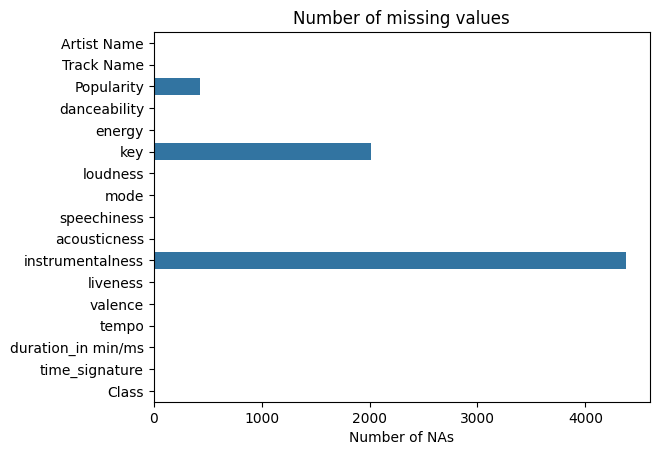

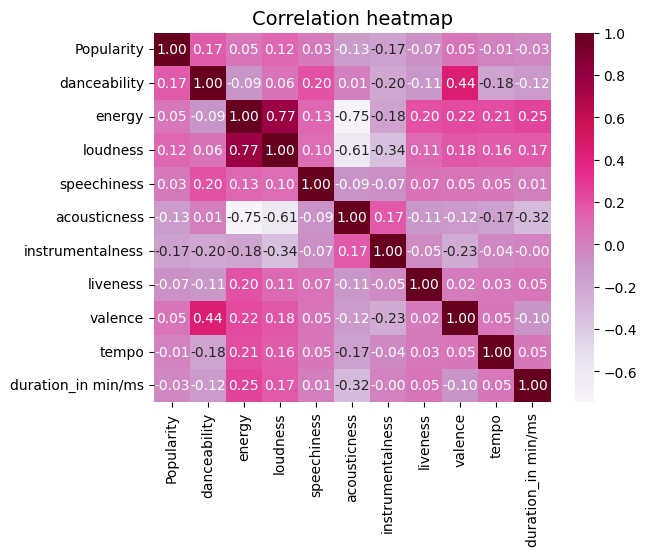

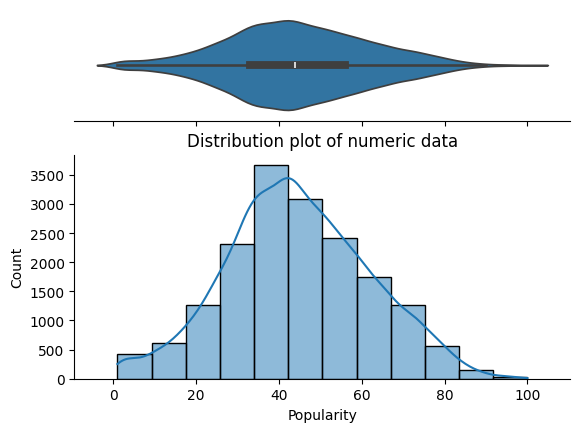

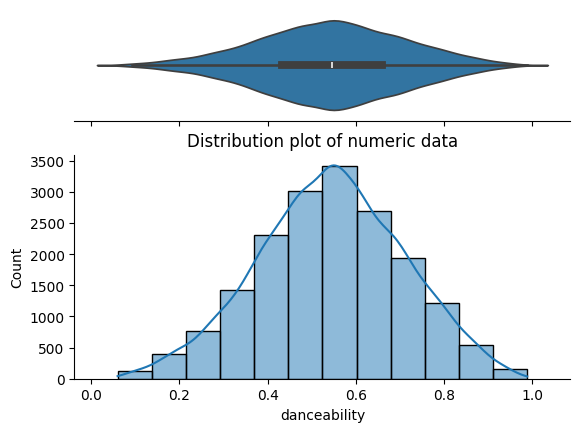

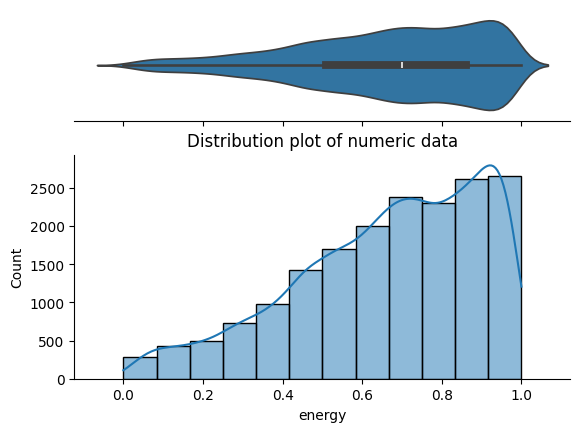

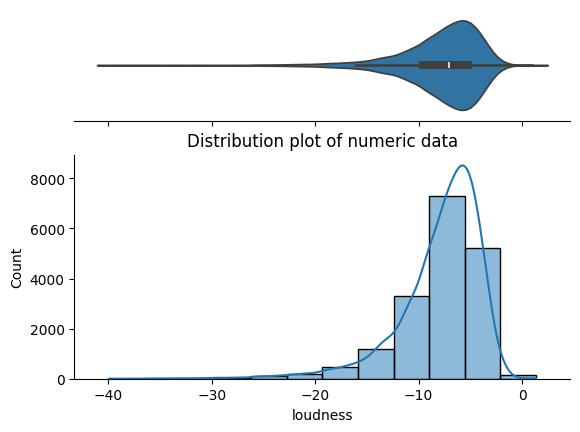

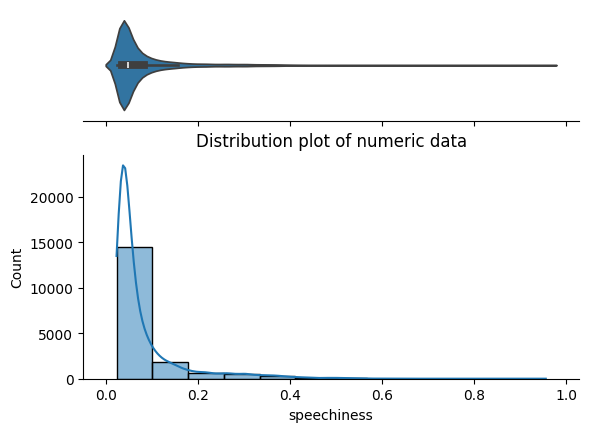

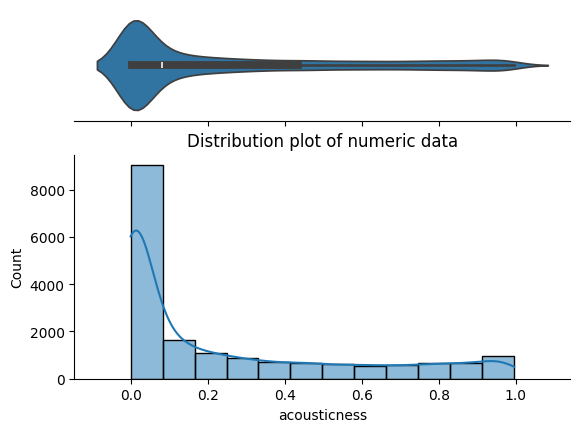

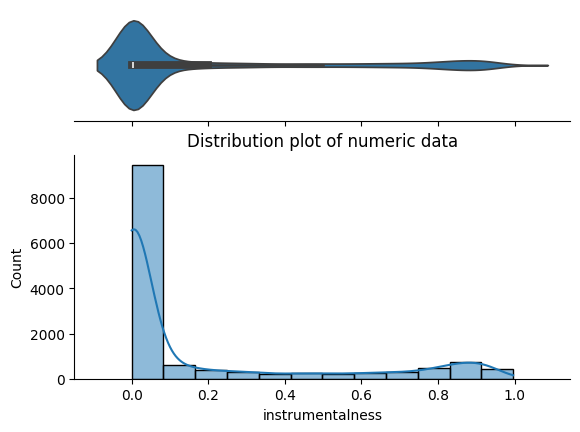

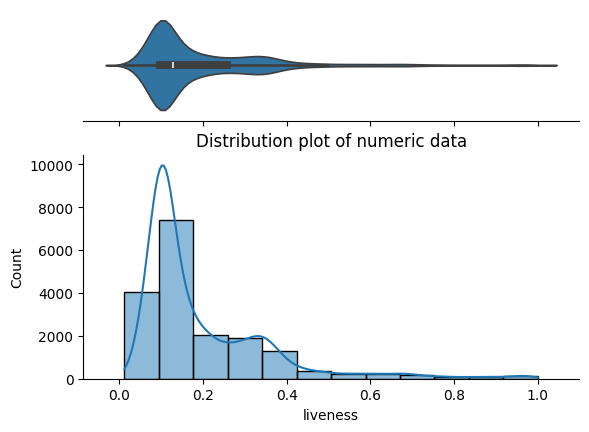

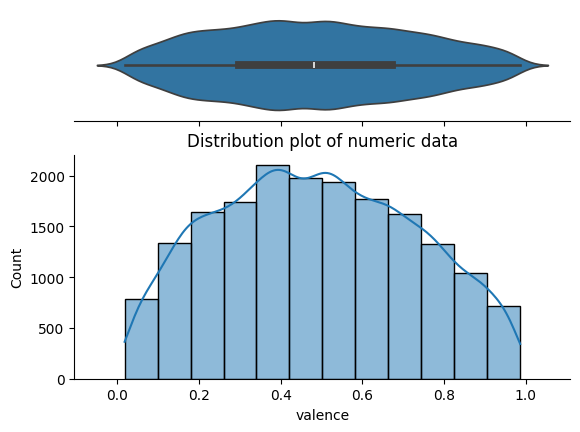

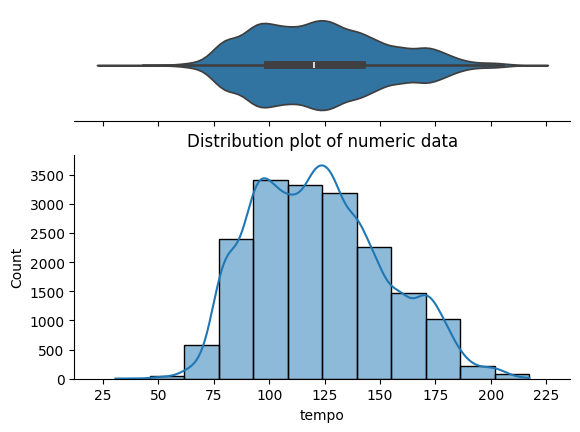

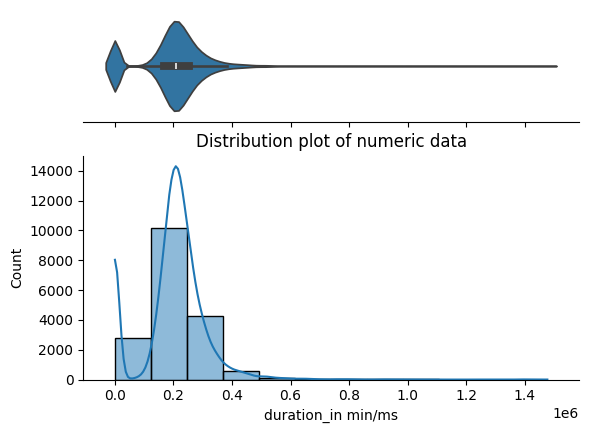

In [5]:
run_eda(data)

У признаки длительность что то не так. Похоже что часть записана в минутах, а часть в милисекундах, это видно на графике скрипке, что у нее есть четко два горба. Переведем одно в другое

In [37]:
data['duration_in min/ms'] = data['duration_in min/ms'] / 60000


Посмотрим на распредление различных количественных признаков в разных классах.

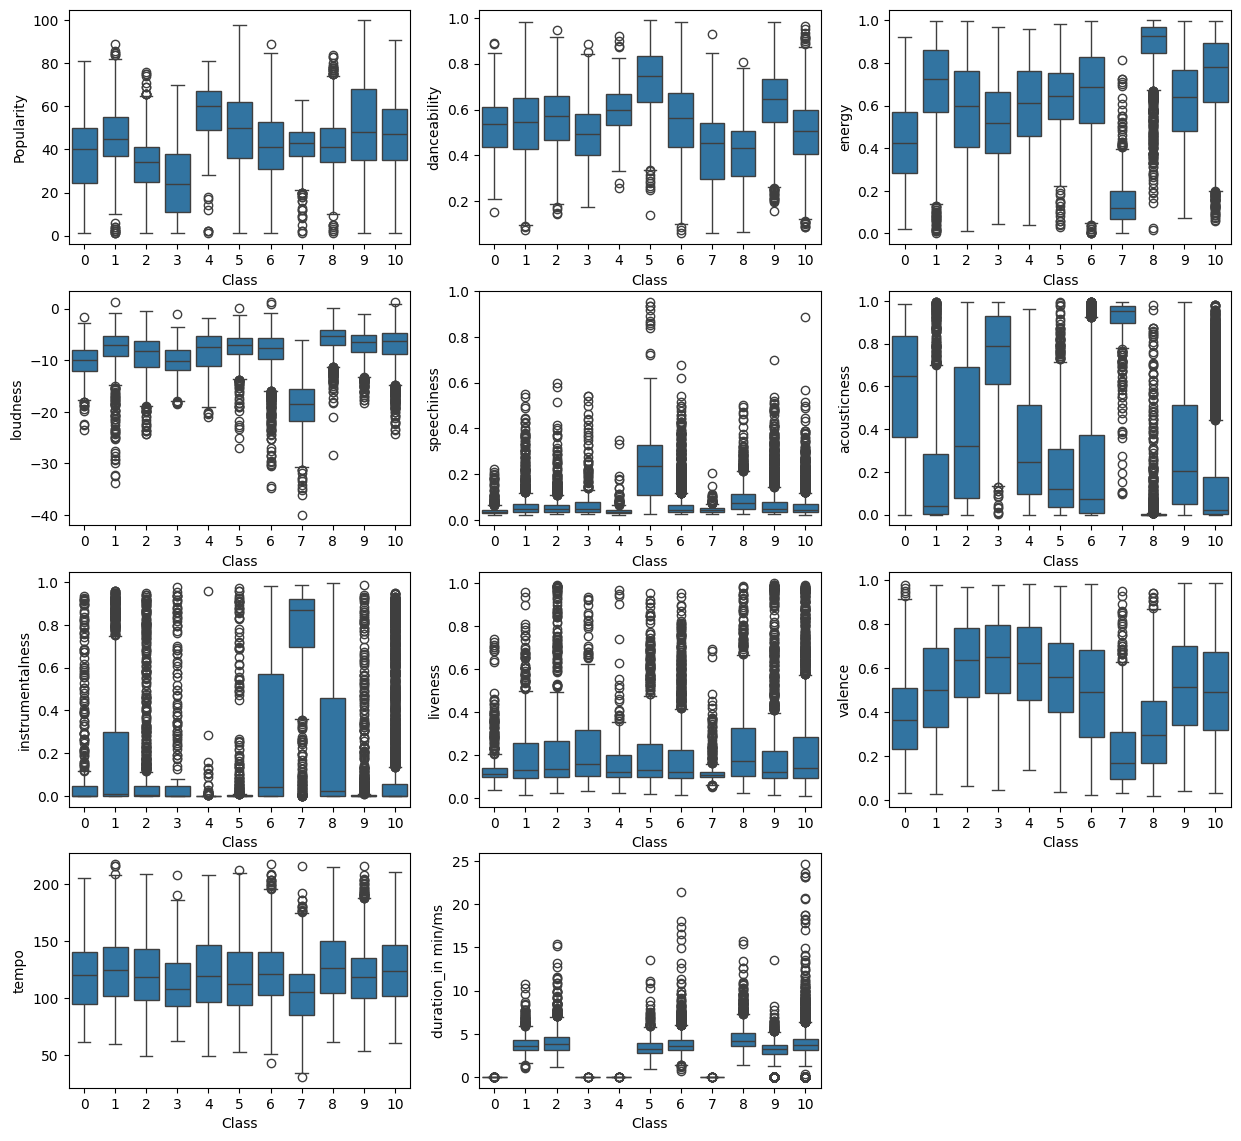

In [23]:
plt.rcParams["figure.figsize"] = 15, 14

names = (['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms'])
for i in range(len(names)):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=data, x=data['Class'], y=data[names[i]].dropna())

Среди выбросов есть треки с продолжительность 20+ минут. Есть и очень короткие треки, видно явно выделяющиеся группы среди них. Думаю что выбросы все же стоит отсечь. Также очень (очень!) много выбросов в критерии инструментальности. Фактически там нет никакой разницы между классами и там же много пропущенных значений. Пытаться заполнить нулями - неверный путь, потому что нулевых значений там в принципе нет, если только среднее или медиану записать. Неуверена, что это хороший шаг. Возможно, этот признак лучше не использовать.

В `speechiness` тоже много выбросов (2034 штук, если считать по квантилям). Тем не менее кажется что это может быть хорошим признаком для вычленения класса 5 относительно остальных.

По `Popularity` есть более или менее популярные. А пропущенные значения можно в принципе заместить медианой например. 

In [39]:
data = data.fillna({'Popularity': data.Popularity.median()})
data.isna().sum()

Artist Name              0
Track Name               0
Popularity               0
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Что делать с `key` и `instrumentalness` неясно, просто заполнить чем то кажется не очень хорошей идеей. Не буду их брать как признаки для классификации, также как и название трека и исполнителя. 

Уберем явные выбросы с помощью квантилей, отбросим верхние и нижние 2 процента данных

In [40]:
names = ['loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_in min/ms']
for name in names:
    q_low = data[name].quantile(0.01)
    q_hi  = data[name].quantile(0.99)

    data = data[(data[name] < q_hi) & (data[name] > q_low)]
data

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,4.195550,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,1.827783,4,6
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,3.832667,4,10
6,Solomon Burke,None Of Us Are Free,48.0,0.674,0.658,5.0,-9.647,0,0.1040,0.404000,0.000001,0.0981,0.6770,143.292,5.489783,4,2
8,Professional Murder Music,Slow,29.0,0.431,0.776,10.0,-5.403,1,0.0527,0.000022,0.001300,0.1790,0.3180,120.857,3.964450,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17989,gnkosaiBAND,ÂÜçËÄÉ,20.0,0.597,0.633,9.0,-8.163,0,0.0971,0.010100,0.211000,0.6310,0.7190,139.969,4.067550,4,9
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,4.284450,4,2
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,3.603700,4,8
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,3.661550,4,8


По хитмапу корреляции есть высоко коррелирующие численные признаки. `energy` и `loudness` обратно коррелируют с `acousticness`, а сами `energy` и `loudness`имеют положительную корреляцию. `valence` (что бы это ни было) также имеет положительную кореляцию с `danceability`. В остальных корреляция не столь высока.

### Категориальные

Распределение данных для категориальных признаков. Виден дисбаланс признаков, в случае `Class`, которую и нужно определить явный перекос к 10 классу. И сильный перекос в `time_signature`, > 15000 значений попадает в одну из категорий

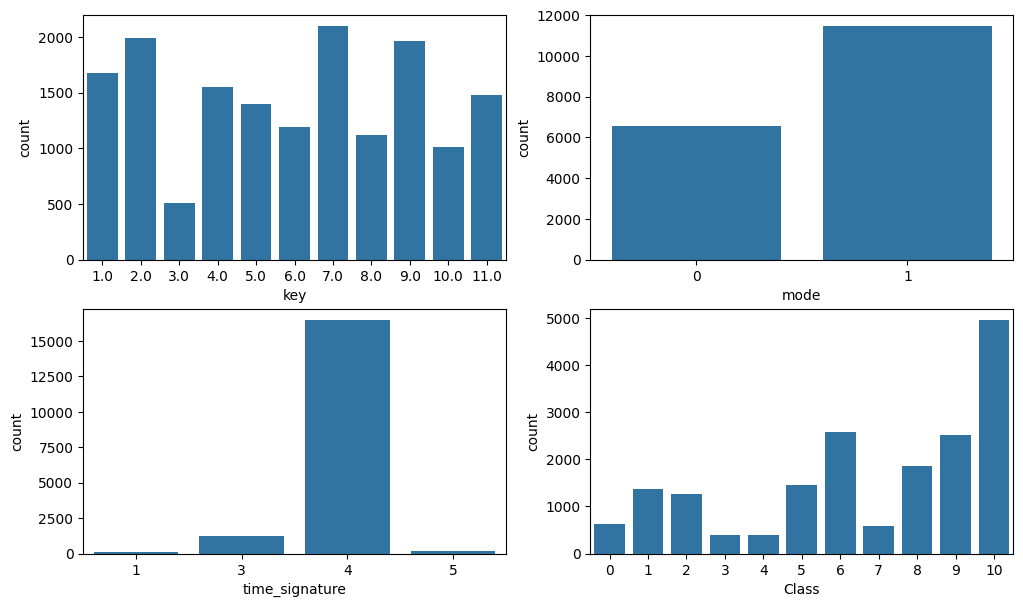

In [10]:
figure, axes = plt.subplots(2, 2, figsize=(12, 7)) 
categ = ['key', 'mode', 'time_signature', 'Class']
sns.barplot(data['key'].value_counts(), ax=axes[0,0])
sns.barplot(data['mode'].value_counts(), ax=axes[0,1])
sns.barplot(data['time_signature'].value_counts(), ax=axes[1,0])
sns.barplot(data['Class'].value_counts(), ax=axes[1,1])
None

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [90]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

y = data.Class
X = data[['Popularity', 'danceability', 'energy', 'speechiness', 'valence', 'duration_in min/ms', 'time_signature', 'mode', 'loudness', 'liveness']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_test

,Popularity,danceability,energy,speechiness,valence,duration_in min/ms,time_signature,mode,loudness,liveness
7865,46.0,0.636,0.668,0.0568,0.666,3.152217,4,1,-6.857,0.0555
4657,52.0,0.522,0.726,0.0383,0.331,3.159783,4,1,-4.115,0.1480
15672,42.0,0.803,0.319,0.1540,0.441,3.829433,4,0,-10.736,0.1030
7821,54.0,0.706,0.329,0.0286,0.232,0.000061,4,1,-10.070,0.1020
1816,53.0,0.623,0.614,0.0309,0.744,3.140217,4,0,-9.240,0.1430
...,...,...,...,...,...,...,...,...,...,...
13576,43.0,0.520,0.982,0.0502,0.723,3.102283,4,0,-3.855,0.1200
14032,51.0,0.323,0.947,0.0912,0.311,4.084217,4,0,-4.234,0.2720
423,48.0,0.638,0.666,0.0392,0.651,3.090917,4,0,-6.951,0.3140
2726,63.0,0.315,0.826,0.0636,0.359,4.267867,4,0,-4.314,0.0703


In [101]:
clf = tree.DecisionTreeClassifier()

param = {'criterion': ['gini', 'entropy'],
         'splitter': ['best', 'random'],
         'max_depth': range(1, 10),
         'min_samples_leaf': range(1,25),
         'class_weight': ['balanced', None]
         }

grid_search = GridSearchCV(clf, param, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
grid_search.best_params_


0.4799807374700752


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 13,
 'splitter': 'best'}

Ну для этого датасета нет явного выбора в пользу одного критерия. Я бы смотрела просто на количество правильных ответов. Потому что это просто жанры музыки, тут не критично не дать неправильный ответ, не упустить True. Если смотреть по метрикам модели, как она предсказывает, то с `balanced accuracy` получается неплохо, лучше, чем с `f1` или `precision`. Остановлюсь пока на этом варианте. 

In [102]:
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test)

print(precision_score(y_test, pred, average='weighted'))
print(recall_score(y_test, pred, average='weighted'))
print(f1_score(y_test, pred, average='weighted'))
print(accuracy_score(y_test, pred))


0.3685177506230014
0.3352810239287702
0.30901443973888465
0.3352810239287702


Деревце

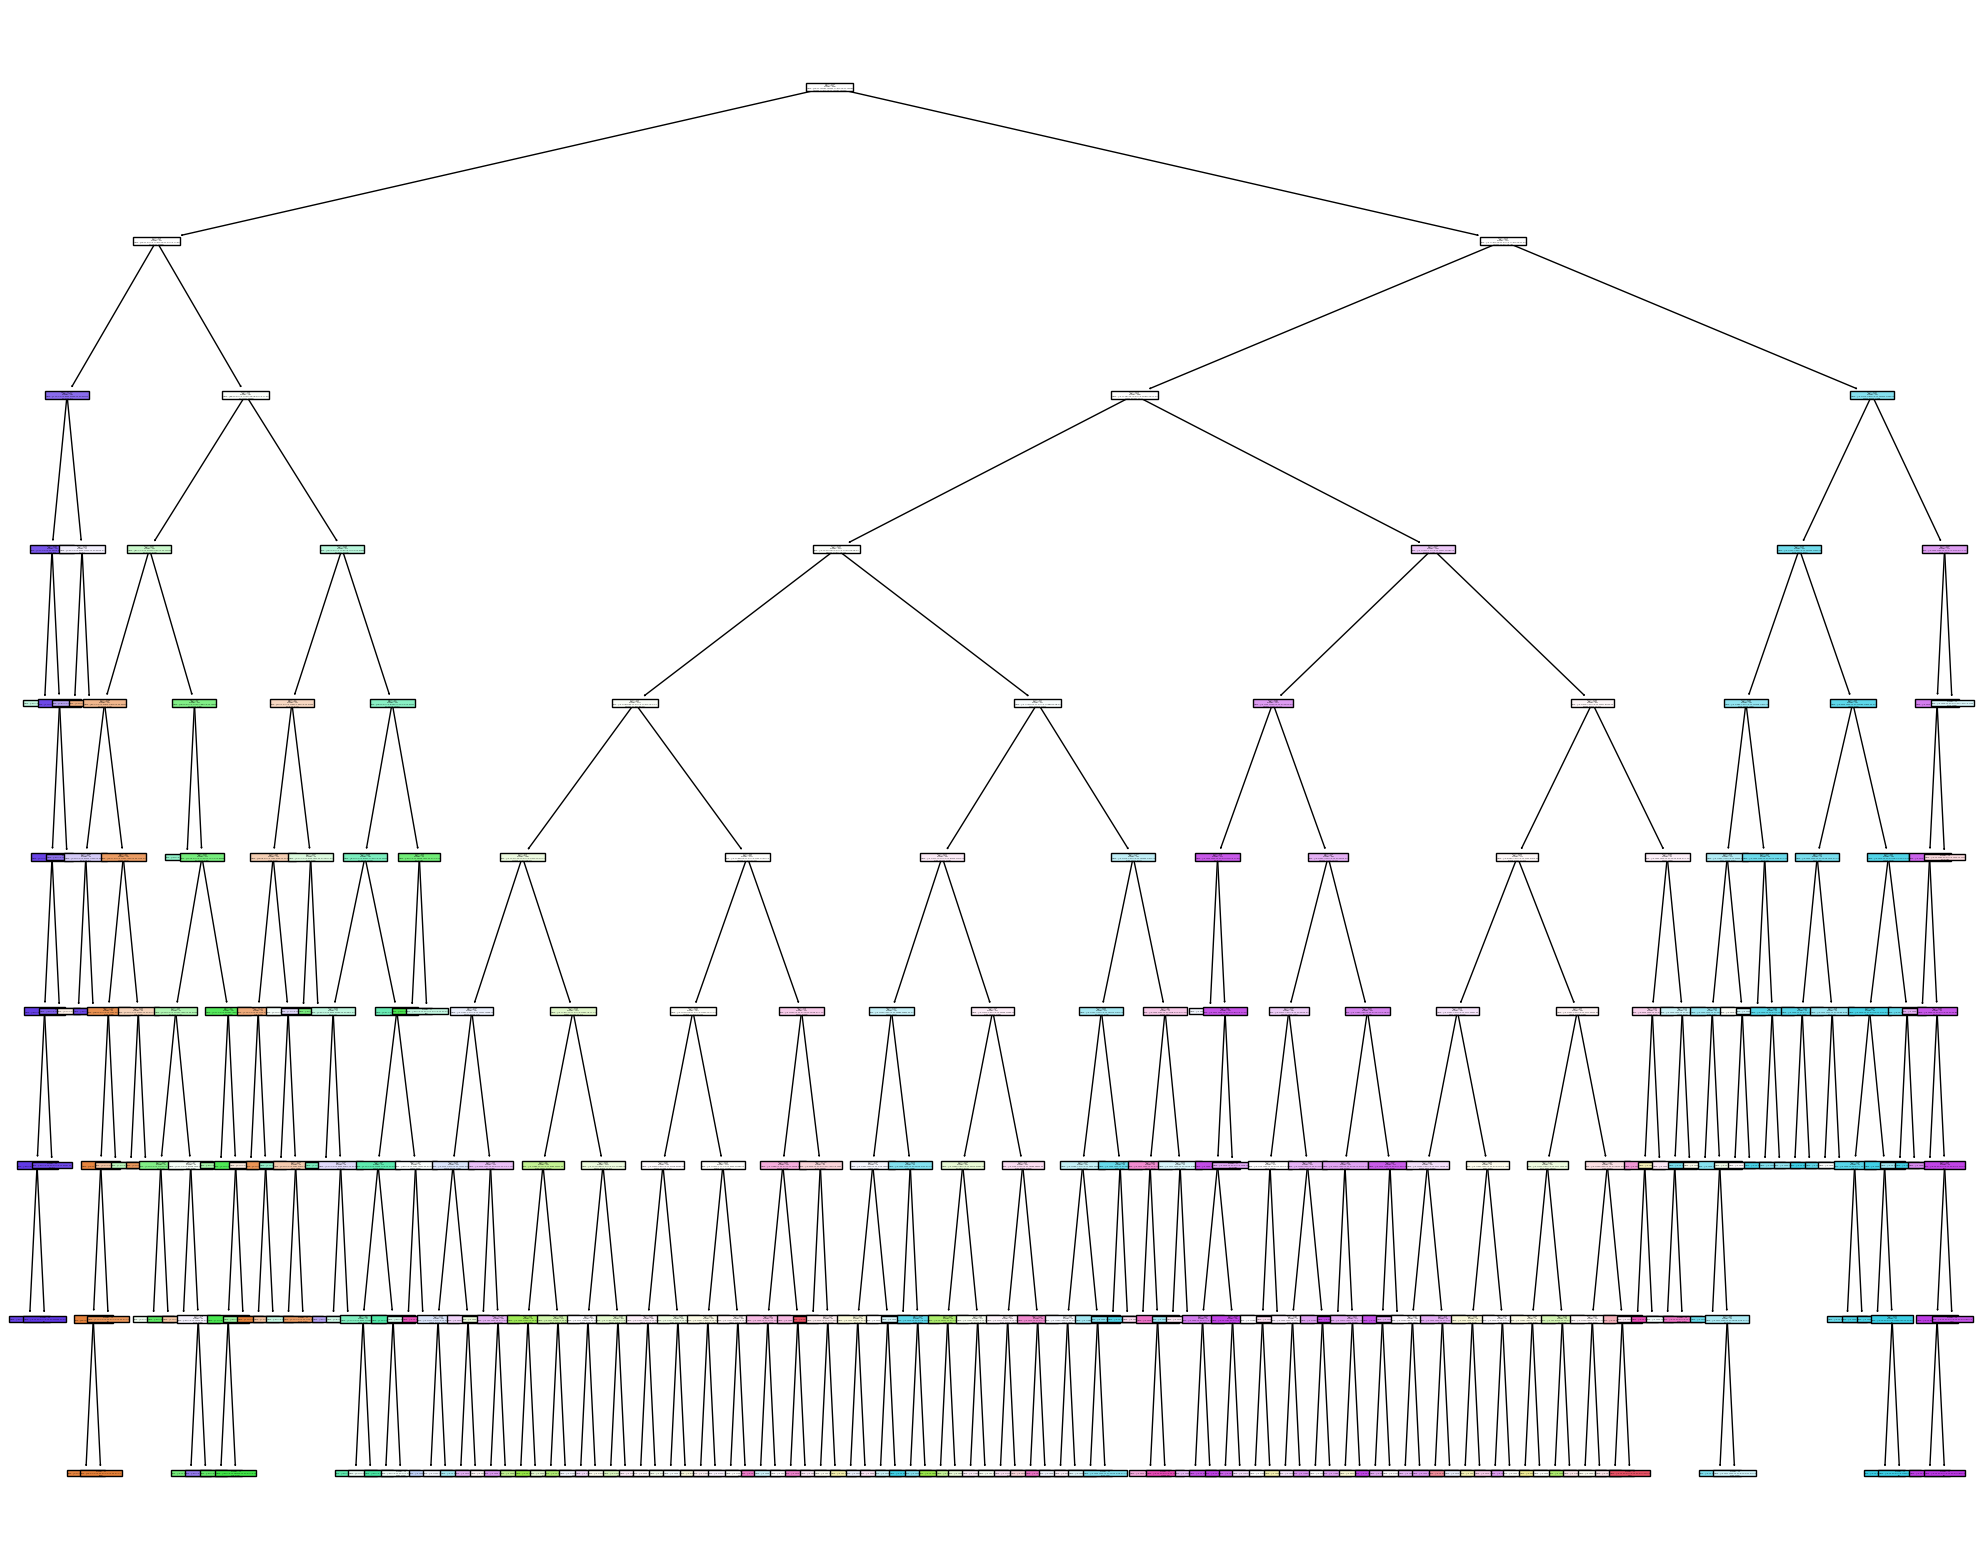

In [103]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_clf, 
                   filled=True)

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.